In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.externals import joblib
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from xgboost import plot_importance
import scipy.stats as ss

In [2]:
# load input dataset
input_dataset = pd.read_csv("dataset.csv", sep=";")
input_dataset.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [3]:
numerical_parameters = ['account_amount_added_12_24m', 'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m', 'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m', 'age', 'avg_payment_span_0_12m', 'avg_payment_span_0_3m', 'max_paid_inv_0_12m', 'max_paid_inv_0_24m', 'num_active_div_by_paid_inv_0_12m', 'num_active_inv', 'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m', 'num_arch_ok_12_24m', 'num_arch_rem_0_12m', 'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m', 'num_unpaid_bills', 'recovery_debt', 'sum_capital_paid_account_0_12m', 'sum_capital_paid_account_12_24m', 'sum_paid_inv_0_12m', 'time_hours']

categorical_parameters = ['account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m', 'account_worst_status_3_6m', 'account_worst_status_6_12m', 'merchant_category', 'merchant_group', 'name_in_email', 'status_last_archived_0_24m', 'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months', 'status_max_archived_0_12_months', 'status_max_archived_0_24_months', 'worst_status_active_inv', 'has_paid']


to_predict = input_dataset.loc[input_dataset['default'].isnull(),]
dataset = input_dataset.loc[~input_dataset['default'].isnull(),]


In [4]:
# check class balance
dataset['default'].value_counts()

0.0    88688
1.0     1288
Name: default, dtype: int64

# Check for missing data


In [5]:
# check for any unusual value in dataset for numerical parameters
for col in numerical_parameters:
    print dataset[col].describe()

count    8.997600e+04
mean     1.227615e+04
std      3.546356e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.984250e+03
max      1.128775e+06
Name: account_amount_added_12_24m, dtype: float64
count    79293.000000
mean         0.217333
std          5.629972
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        362.000000
Name: account_days_in_dc_12_24m, dtype: float64
count    79293.000000
mean         5.073840
std         22.957817
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        365.000000
Name: account_days_in_rem_12_24m, dtype: float64
count    79293.000000
mean         0.287894
std          2.930697
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         97.000000
Name: account_days_in_term_12_24m, dtype: float64
count    36619.000000
mean         1.330536
std         26.924730
min          0.000000
25%        

In [6]:
# check for fields with large number of missing values

drop_columns_due_to_missing_data = []
for col in dataset.columns:
    missing_percent = float(len(dataset.loc[dataset[col].isnull()]))/len(dataset) *100
    if missing_percent > 10.0:
        print str(col) + ":  "+ str(float(len(dataset.loc[dataset[col].isnull()]))/len(dataset))
        drop_columns_due_to_missing_data.append(col)

account_days_in_dc_12_24m:  0.118731661776
account_days_in_rem_12_24m:  0.118731661776
account_days_in_term_12_24m:  0.118731661776
account_incoming_debt_vs_paid_0_24m:  0.59301369254
account_status:  0.543856139415
account_worst_status_0_3m:  0.543856139415
account_worst_status_12_24m:  0.667455765982
account_worst_status_3_6m:  0.577242820308
account_worst_status_6_12m:  0.603638748111
avg_payment_span_0_12m:  0.238596959189
avg_payment_span_0_3m:  0.493264870632
num_active_div_by_paid_inv_0_12m:  0.229594558549
num_arch_written_off_0_12m:  0.181214990664
num_arch_written_off_12_24m:  0.181214990664
worst_status_active_inv:  0.69507424202


In [7]:
# find the relevance of each of the above features in identifying the dependent variable
for col in drop_columns_due_to_missing_data:
    print dataset.loc[dataset.default==1.0, col].value_counts().nlargest(10)

0.0      1152
42.0        4
9.0         4
56.0        3
67.0        3
134.0       2
58.0        2
64.0        1
48.0        1
92.0        1
Name: account_days_in_dc_12_24m, dtype: int64
0.0     824
15.0     10
29.0      8
64.0      8
42.0      8
3.0       7
23.0      7
50.0      7
1.0       7
17.0      7
Name: account_days_in_rem_12_24m, dtype: int64
0.0     1077
34.0      34
1.0       13
21.0       6
29.0       5
15.0       5
2.0        4
19.0       4
16.0       3
40.0       3
Name: account_days_in_term_12_24m, dtype: int64
0.000000    128
7.559546      8
1.355379      4
0.079432      3
0.969055      3
1.228032      3
1.898182      3
1.235571      3
6.217660      3
0.522500      3
Name: account_incoming_debt_vs_paid_0_24m, dtype: int64
1.0    668
2.0    163
4.0      3
3.0      2
Name: account_status, dtype: int64
1.0    406
2.0    350
3.0     57
4.0     23
Name: account_worst_status_0_3m, dtype: int64
2.0    251
1.0    164
3.0     80
4.0     45
Name: account_worst_status_12_24m, dtype

In [8]:
for col in drop_columns_due_to_missing_data:
    print dataset['default'].groupby(dataset[col]).value_counts().nlargest(10)

account_days_in_dc_12_24m  default
0.0                        0.0        77909
                           1.0         1152
28.0                       0.0            8
9.0                        0.0            7
7.0                        0.0            6
35.0                       0.0            6
43.0                       0.0            6
99.0                       0.0            6
3.0                        0.0            5
36.0                       0.0            5
Name: default, dtype: int64
account_days_in_rem_12_24m  default
0.0                         0.0        69751
                            1.0          824
1.0                         0.0          478
2.0                         0.0          285
21.0                        0.0          234
15.0                        0.0          205
16.0                        0.0          198
14.0                        0.0          193
3.0                         0.0          188
22.0                        0.0          173
Name: defau

Summary: Drop all these feature. There is no useful information from these column.
    
'num_arch_written_off_0_12m' has default==1.0 for only 1 possible value, so it might be important but the overall distribution of this feature is also such that it has 0.0 value 99.9% of the time. Similarly for num_arch_written_off_12_24m. Hence these features can be discarded as well.

NOTE: the other way to handle these parameters with high ratio of missing value would be to convert these continuous parameters into categorical variable (cut into different ranges- missing value also treated as one of the category). Then find the relevance of these variables and decide whether to keep them or discard them. 

In [10]:
dataset = dataset.drop(columns=drop_columns_due_to_missing_data, axis=1)

In [11]:
# check for missing values in leftover columns for data imputation
dataset.isnull().values.any()

False

# Feature selection: numeric features

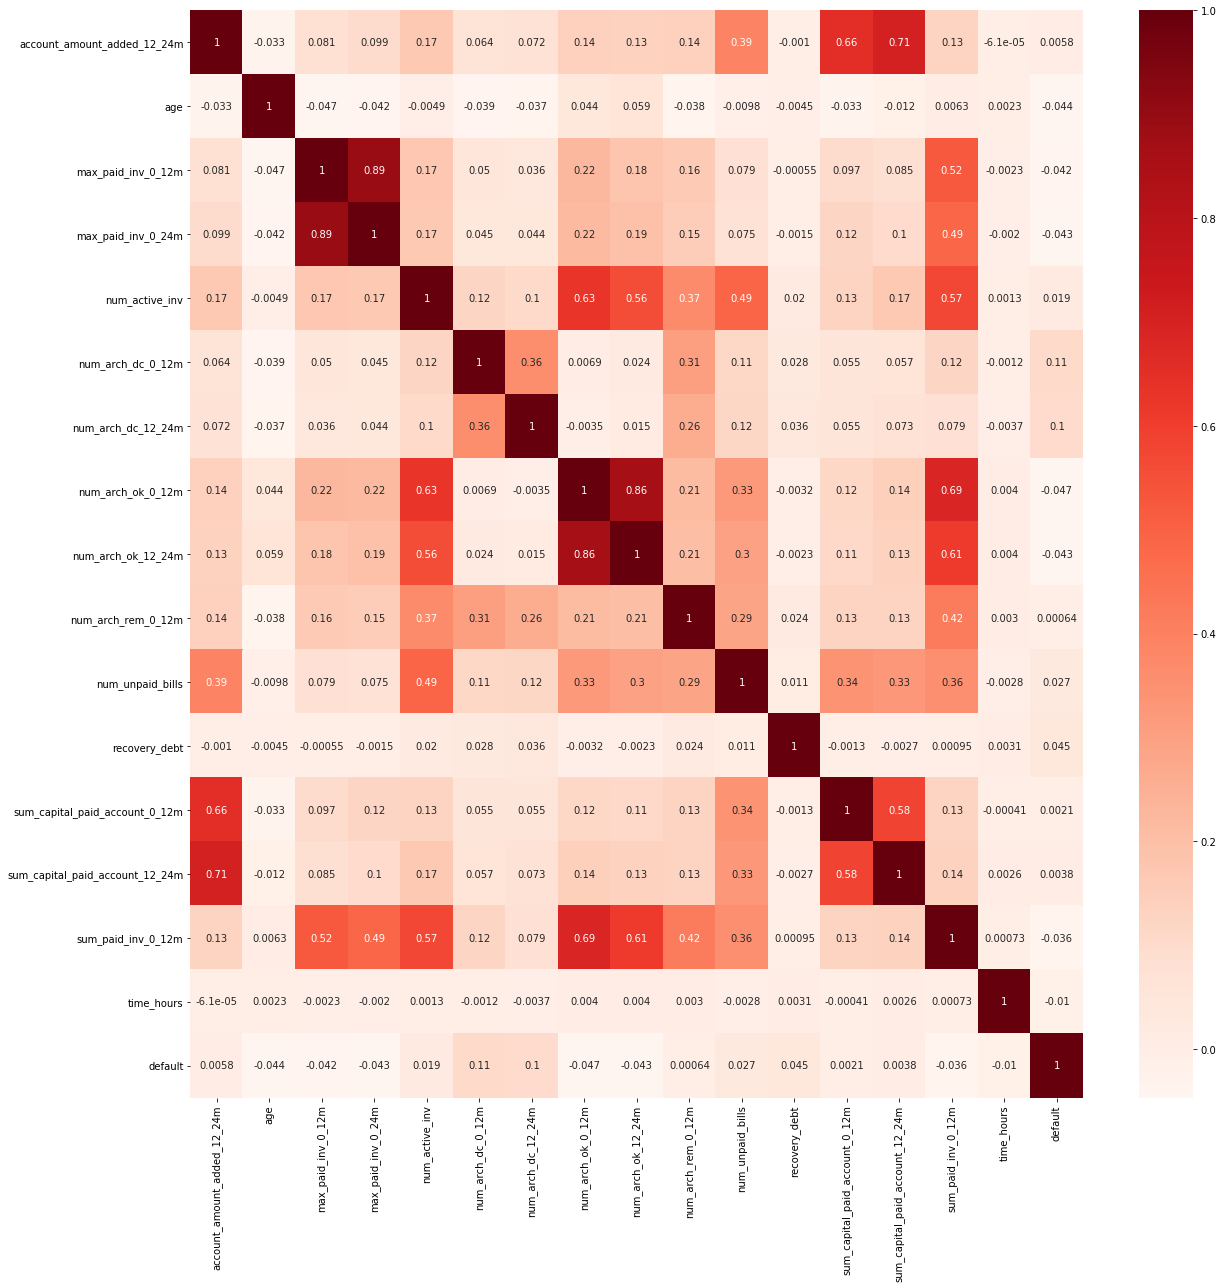

In [12]:
# check for correlation between numerical features
numericX = [col for col in numerical_parameters if col in dataset.columns]
numericX.append('default')
plt.figure(figsize=(20,20))
cor = dataset[numericX].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- No highly correlated parameter with the output variable.
- 'max_paid_inv_0_12m' and 'max_paid_inv_0_24m' are highly correlated. In such cases we usually keep one of the parameters which is more correlated to output variable. Here since both are almost equally correlated with output variable, a new aggregated field can be formed instead of discarding one of them.
- Similar case for 'num_arch_dc_0_12m' and 'num_arch_dc_12_24m', 'num_arch_ok_0_12m' and 'num_arch_ok_12_24m', 'sum_capital_paid_account_0_12m' and 'sum_capital_paid_account_12_24m'.

In [13]:
# aggregate highly correlated numeric parameters to replace them by their average score 
dataset['max_paid_inv'] = (dataset['max_paid_inv_0_12m'] + dataset['max_paid_inv_0_24m'])/2.0
dataset['num_arch_ok'] = (dataset['num_arch_ok_0_12m'] + dataset['num_arch_ok_12_24m'])/2.0
dataset['num_arch_dc'] = (dataset['num_arch_dc_0_12m'] + dataset['num_arch_dc_12_24m'])/2.0
dataset['sum_capital_paid_account'] = (dataset['sum_capital_paid_account_0_12m'] + dataset['sum_capital_paid_account_12_24m'])/2.0

dataset = dataset.drop(['max_paid_inv_0_12m', 'max_paid_inv_0_24m', 'num_arch_ok_0_12m' , 'num_arch_ok_12_24m', 'num_arch_dc_0_12m' , 'num_arch_dc_12_24m', 'sum_capital_paid_account_0_12m' , 'sum_capital_paid_account_12_24m'], axis=1)

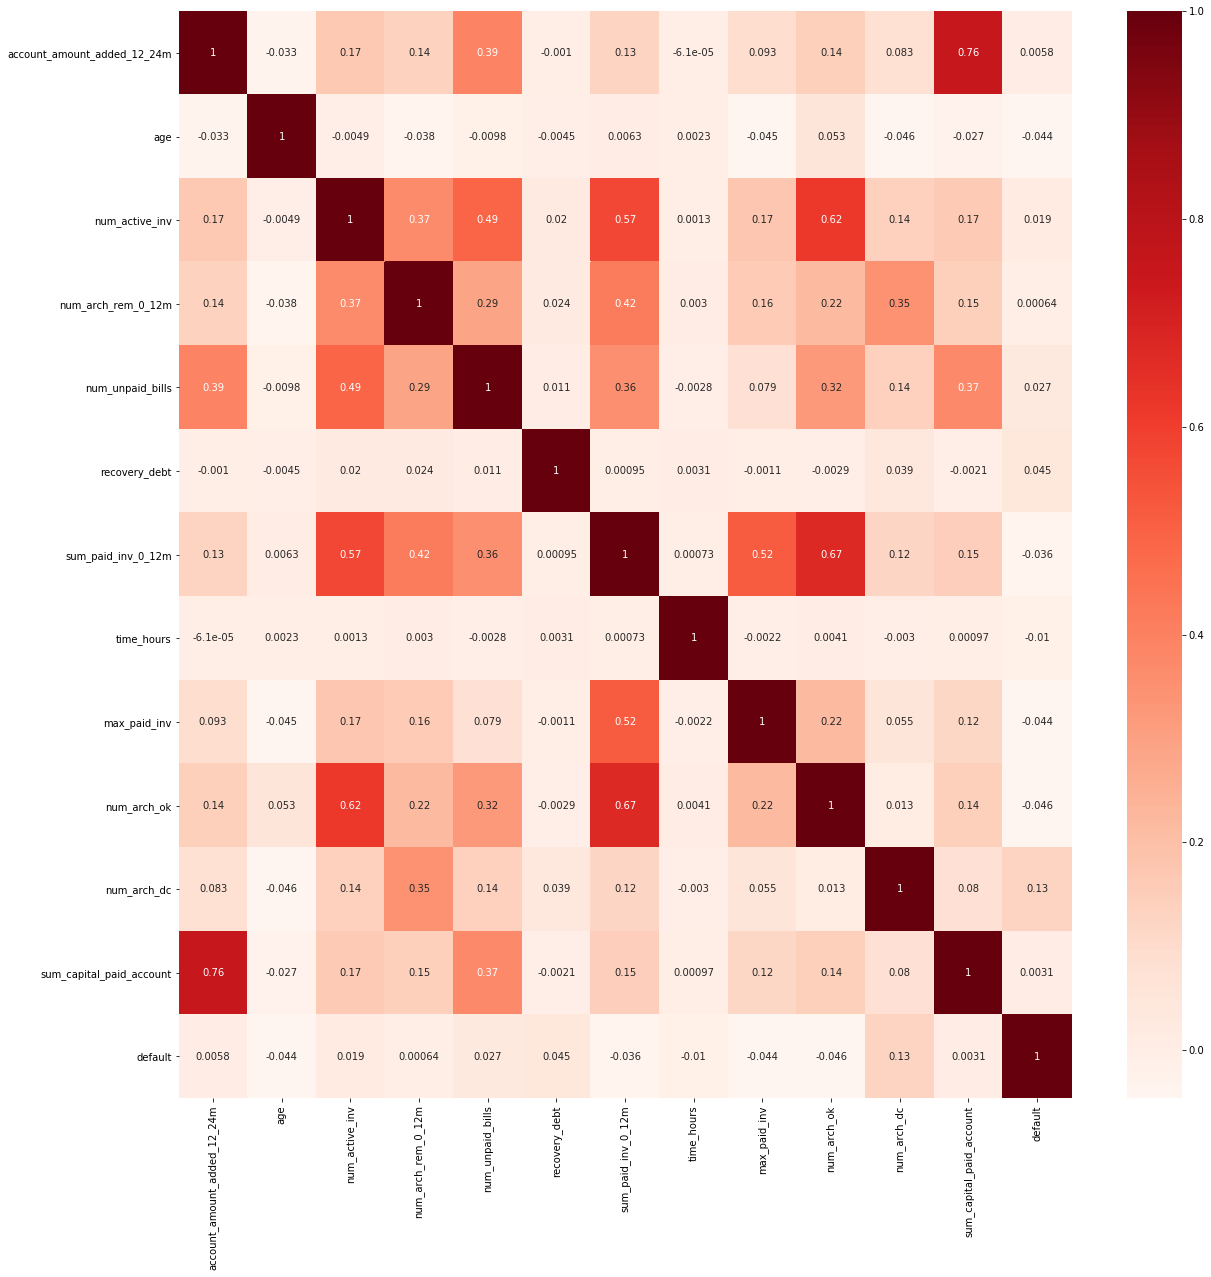

In [14]:
# check for correlation again between numerical features with the new created numeric features
numericX = [col for col in numerical_parameters if col in dataset.columns]
new_numeric_columns = ['max_paid_inv', 'num_arch_ok' , 'num_arch_dc', 'sum_capital_paid_account']
for col in new_numeric_columns:
    numericX.append(col)
numericX.append('default')
plt.figure(figsize=(20,20))
cor = dataset[numericX].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- 'account_amount_added_12_24m' is highly correlated to 'sum_capital_paid_account'. Keep 'account_amount_added_12_24m' since is more correlated to 'default'.
- 'num_active_inv' is highly correlated to 'num_arch_ok', 'sum_paid_inv_0_12m' and 'num_unpaid_bills', all which have higher correlation with 'default'. Drop this feature.
- 'num_arch_rem_0_12m' is too less correlated with 'default'. Drop this feature.
- 'sum_paid_inv_0_12m' highly correlated with 'num_arch_ok' and 'max_paid_inv'. Drop this feature.



In [15]:
correlated_drop_feature_list = ['sum_capital_paid_account', 'num_active_inv', 'num_arch_rem_0_12m', 'sum_paid_inv_0_12m']
dataset = dataset.drop(correlated_drop_feature_list, axis=1)

# Feature selection: categorical features

Using Cramer's V to find association between catgorical data.
Cramer's V is based on a nominal variation of Pearson’s Chi-Square Test, and comes built-in with some great benefits:
1. Similarly to correlation, the output is in the range of [0,1], where 0 means no association and 1 is full association. (Unlike correlation, there are no negative values, as there’s no such thing as a negative association. Either there is, or there isn’t)
2. Like correlation, Cramer’s V is symmetrical — it is insensitive to swapping x and y

In [16]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [17]:
categoricalX = [col for col in categorical_parameters if col in dataset.columns]
for col in categoricalX:
    corr = cramers_v(dataset['default'], dataset[col])
    print col, corr

merchant_category 0.10032464834918958
merchant_group 0.08165060770711174
name_in_email 0.026025133514102024
status_last_archived_0_24m 0.16959899863789232
status_2nd_last_archived_0_24m 0.14244318561812286
status_3rd_last_archived_0_24m 0.12094502669226868
status_max_archived_0_6_months 0.10273279081696528
status_max_archived_0_12_months 0.1302921663818598
status_max_archived_0_24_months 0.13583228636068764
has_paid 0.031949920559470824


In [18]:
# since name_in_email and has_paid are not well correlated with default, eliminate them
dataset = dataset.drop(['name_in_email', 'has_paid'], axis=1)

In [19]:
# get dummy variables for categorical parameters
categoricalX = [col for col in categorical_parameters if col in dataset.columns]
new_cat_names = []
catX = pd.DataFrame()
for col in categoricalX:
    cat_col = col+"_cat"
    new_cat_names.append(cat_col)
    cat_col = pd.get_dummies(pd.Categorical(pd.Series(dataset[col])), prefix=col, drop_first=True)
    catX = pd.concat([catX, cat_col], axis=1)
    
catX.head()

,merchant_category_Automotive Parts & Accessories,merchant_category_Bags & Wallets,merchant_category_Body & Hair Care,merchant_category_Books & Magazines,merchant_category_Car electronics,merchant_category_Children Clothes & Nurturing products,merchant_category_Children toys,merchant_category_Cleaning & Sanitary,merchant_category_Collectibles,merchant_category_Concept stores & Miscellaneous,...,status_max_archived_0_6_months_2,status_max_archived_0_6_months_3,status_max_archived_0_12_months_1,status_max_archived_0_12_months_2,status_max_archived_0_12_months_3,status_max_archived_0_12_months_5,status_max_archived_0_24_months_1,status_max_archived_0_24_months_2,status_max_archived_0_24_months_3,status_max_archived_0_24_months_5
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


Estimate mutual information for default from the expanded categorical data.
Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
This will help to find expanded categorical features that are related to output variable.

In [20]:
Y = dataset['default']
pmi = mutual_info_classif(catX, Y)
pmi_df = pd.DataFrame(pmi)
pmi_df.columns = ['pmi']
pmi_df.sort_values(by=['pmi'], inplace = True, ascending = False)
print pmi_df['pmi'].describe()

count    90.000000
mean      0.001255
std       0.003009
min       0.000000
25%       0.000000
50%       0.000205
75%       0.000719
max       0.017141
Name: pmi, dtype: float64


In [21]:
drop_column_list = []
for i in pmi_df.loc[pmi_df['pmi'] < 0.0012,].index:
    drop_column_list.append(catX.columns[i])
print drop_column_list
catX = catX.drop(list(drop_column_list), axis = 1)
print "number of selected features: ", catX.shape[1]

['status_max_archived_0_6_months_3', 'status_3rd_last_archived_0_24m_3', 'merchant_category_Youthful Shoes & Clothing', 'merchant_category_Dating services', 'merchant_group_Erotic Materials', 'merchant_group_Intangible products', 'merchant_category_Body & Hair Care', 'merchant_category_Prints & Photos', 'merchant_category_Food & Beverage', 'merchant_category_Children toys', 'merchant_category_Music & Movies', 'status_max_archived_0_6_months_2', 'merchant_category_Video Games & Related accessories', 'merchant_group_Health & Beauty', 'merchant_category_Fragrances', 'merchant_category_Hobby articles', 'merchant_category_Diversified erotic material', 'merchant_category_Cleaning & Sanitary', 'merchant_group_Jewelry & Accessories', 'status_2nd_last_archived_0_24m_2', 'merchant_group_Food & Beverage', 'merchant_category_Costumes & Party supplies', 'merchant_category_Diversified Jewelry & Accessories', 'merchant_category_Books & Magazines', 'merchant_category_Pharmaceutical products', 'merchan

# Create training data

In [22]:
# scale numeric parametes to have values between 0-1.
numericalX = [col for col in dataset.columns if col not in ['uuid', 'default'] and col not in categoricalX]
numX = dataset[numericalX]
scaler = MinMaxScaler()
scaler.fit(numX)
num_data = pd.DataFrame(scaler.transform(numX), columns = numX.columns)
num_data.head()

,account_amount_added_12_24m,age,num_unpaid_bills,recovery_debt,time_hours,max_paid_inv,num_arch_ok,num_arch_dc
0,0.0,0.024390,0.010989,0.0,0.402220,0.113398,0.054,0.0
1,0.0,0.390244,0.000000,0.0,0.549226,0.049280,0.056,0.0
2,0.0,0.048780,0.005495,0.0,0.481747,0.107133,0.022,0.0
3,0.0,0.219512,0.005495,0.0,0.656300,0.143513,0.104,0.0
4,0.0,0.085366,0.000000,0.0,0.529109,0.025448,0.002,0.0


In [23]:
X = pd.concat([num_data, catX], axis=1)
Y = dataset['default']
print X.shape, Y.shape

(89976, 23) (89976,)


# Applying Backward elimination for further feature selection
Selection of ML algorithm: A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. A better approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library. Motivated by this, I tried a variety of anomaly-detection and supervised learning approaches. I find, however, that the best result is obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. XGBoost allows for weighting the positive class more compared to the negative class --- a setting that also allows to account for the skew in the data.

In [24]:
#Split the data into training and test sets in a 80:20 ratio
randomState = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

weights = (Y==0).sum()/(1.0 *  (Y==1).sum())
xgb_classifier1 = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
xgb_prediction1 = xgb_classifier1.fit(X_train, Y_train).predict(X_train)

/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


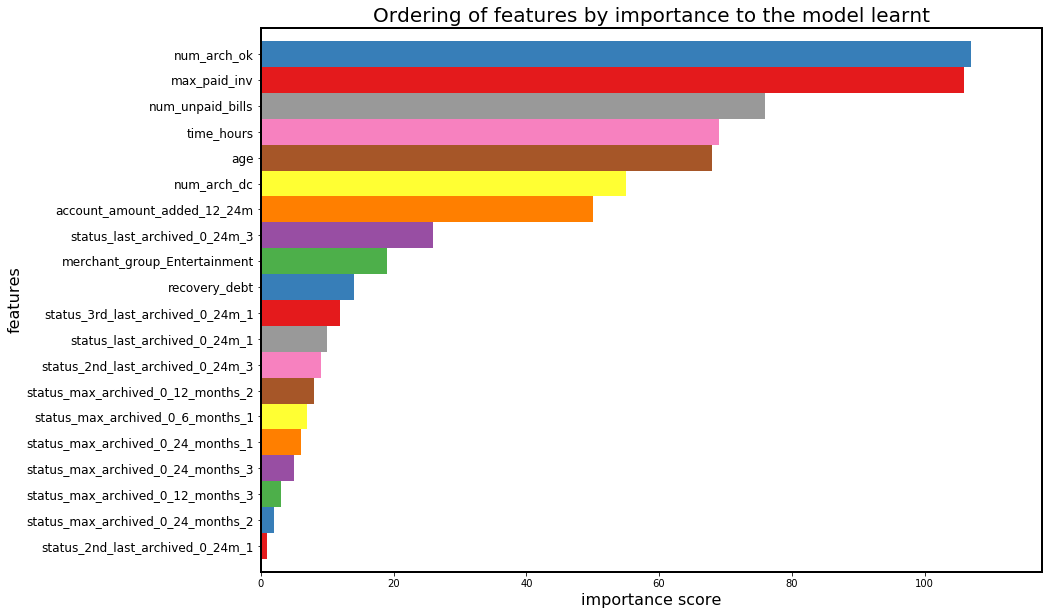

In [25]:
fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(xgb_classifier1, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'weight', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

In [26]:
sorted_idx = np.argsort(xgb_classifier1.feature_importances_)[::-1]

important_features = []
for index in sorted_idx:
    print([X_train.columns[index], xgb_classifier1.feature_importances_[index]])
    if xgb_classifier1.feature_importances_[index] > 0.010:
        important_features.append(X_train.columns[index])
        
print important_features

['num_arch_ok', 0.16385911]
['max_paid_inv', 0.16232772]
['num_unpaid_bills', 0.116385914]
['time_hours', 0.10566615]
['age', 0.10413476]
['num_arch_dc', 0.084226646]
['account_amount_added_12_24m', 0.07656968]
['status_last_archived_0_24m_3', 0.039816234]
['merchant_group_Entertainment', 0.029096479]
['recovery_debt', 0.02143951]
['status_3rd_last_archived_0_24m_1', 0.018376723]
['status_last_archived_0_24m_1', 0.0153139355]
['status_2nd_last_archived_0_24m_3', 0.013782542]
['status_max_archived_0_12_months_2', 0.012251149]
['status_max_archived_0_6_months_1', 0.010719755]
['status_max_archived_0_24_months_1', 0.0091883615]
['status_max_archived_0_24_months_3', 0.0076569677]
['status_max_archived_0_12_months_3', 0.0045941807]
['status_max_archived_0_24_months_2', 0.0030627872]
['status_2nd_last_archived_0_24m_1', 0.0015313936]
['merchant_group_Clothing & Shoes', 0.0]
['merchant_category_Diversified entertainment', 0.0]
['status_max_archived_0_12_months_1', 0.0]
['num_arch_ok', 'max_pa

In [28]:
non_important_discared_features = set(X.columns) - set(important_features)
print non_important_discared_features

set(['status_max_archived_0_12_months_3', 'status_max_archived_0_12_months_1', 'merchant_category_Diversified entertainment', 'status_max_archived_0_24_months_2', 'status_max_archived_0_24_months_3', 'status_max_archived_0_24_months_1', 'status_2nd_last_archived_0_24m_1', 'merchant_group_Clothing & Shoes'])


# Model tuning
Selection of metric: It is a skewed classification(prob prediction) problem. AUC-ROC is not sensitive to imbalance. A better metric would be AUPRC, since it is more sensitive to differences between algorithms and their parameter settings rather than the AUC-ROC.
In problems like this (default detection), it is often good to use business based derived metrices like precision@recall or recall@precision. In this case, we want high recall to have many possible defaults detected but also making sure that a good percent of them are actual defaults. Hence here I am using precision@recall.

In [29]:
X = X[important_features]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

In [30]:
# find best hyperparameters
# (I have taken some sample values to run this method. This can be optimised further.)
 

print("Parameter optimization")
weights = (Y==0).sum()/(1.0*(Y==1).sum())
xgb_model = XGBClassifier(scale_pos_weight = weights, objective="binary:logistic")
clf = GridSearchCV(xgb_model,
                   {'learning_rate': [0.2, 0.4, 0.6, 0.8],
                    'gamma': [0.1, 0.3, 0.5, 0.7, 0.9]}, scoring='f1')
clf.fit(X,Y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization


/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.10779715053323784
{'learning_rate': 0.8, 'gamma': 0.3}


In [56]:
# kFold cross validation 
randomState = 5
precision_score = []
recall_score = []

max_precision = 0

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)
for train_index, test_index in skf.split(X, Y):
    weights = (Y==0).sum()/(1.0 *  (Y==1).sum())
    xgb_model = XGBClassifier(scale_pos_weight = weights, learning_rate=0.8, gamma=0.3, objective="binary:logistic").fit(X.iloc[train_index], Y[train_index])
    predictions = xgb_model.predict(X.iloc[test_index])
    actuals = Y[test_index]
    tn, fp, fn, tp = confusion_matrix(actuals, predictions).ravel()
    print confusion_matrix(actuals, predictions)
    precision = float(tp)/float(tp+fp)*100
    recall = float(tp)/float(tp+fn)*100
    print "precision", precision
    print "recall", recall
    print "**********************"
    precision_score.append(precision)
    recall_score.append(recall)
    
    if precision > max_precision:
        max_precision = precision
        filename = 'prediction_model.sav'
        joblib.dump(xgb_classifier, filename)
        print "saving model for :", precision
    


/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[15044  2694]
 [   81   177]]
precision 6.16509926855
recall 68.6046511628
**********************
saving model for : 6.16509926855


/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[15086  2652]
 [  103   155]]
precision 5.52190951193
recall 60.0775193798
**********************


/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[15018  2720]
 [   96   162]]
precision 5.62109646079
recall 62.7906976744
**********************


/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[14968  2769]
 [   83   174]]
precision 5.9123343527
recall 67.7042801556
**********************
[[14974  2763]
 [   94   163]]
precision 5.57074504443
recall 63.4241245136
**********************


/Users/ruchijuneja/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
# Write scalar file for it to be used in the API
scaler_filename = "scaler.sav"
joblib.dump(scaler, scaler_filename)

['scaler.sav']